# Volumeter
To start up the system, run the cell below.

Temperature sensor is not working. Using default 20°C.


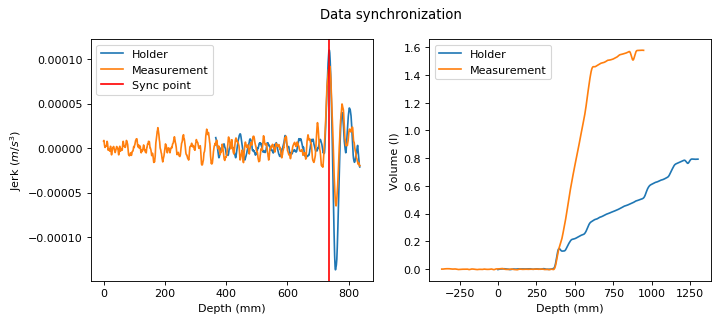

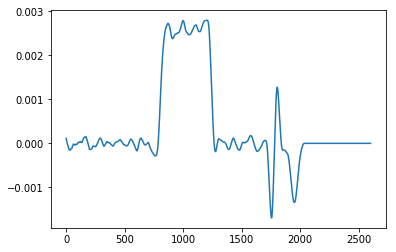

1299.5    0.977466
1300.0    0.977466
1300.5    0.977466
1301.0    0.977466
1301.5    0.977466
Name: Force, dtype: float64
Total volume: 0.98 l
Specimen weight: 8639.99 g
Specimen density: 8839.17 kg/m^3
Water temperature: 20.00°C


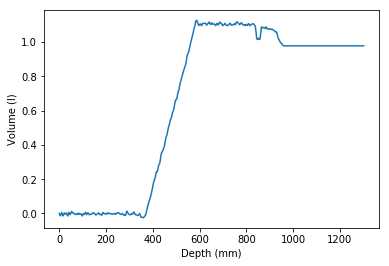

In [ ]:
import import_ipynb
from backend.Backend_notebook import *
start()

# TODO
- Kommenttikenttä
- Hyväksy mittaus
- Laske tilavuus
- Leikka diff jos jompi kumpi data loppuu kesken

In [ ]:
saveHolder(None,None)